# Lab 2
## Louis Gauthy (i6188059) & Louis Meeckers (i6258699)

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from PIL import Image
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

ssl._create_default_https_context = ssl._create_unverified_context

# Load the data

In [148]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Concatenate
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# 80% train, 10% validation, 10% test
x_train, x_test, _, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_validation, x_test, _, _ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Print shape
print (x_train.shape) # 80% => 48 000 instances
print (x_validation.shape) # 10% => 6 000 instances
print (x_test.shape) # 10% => 6 000 instances

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [5]:
print("max pixel values = ",np.max(x_train))
print("max pixel values = ",np.min(x_train))

1.0
0.0


# Reconstruction

## Create autoencoder

In [144]:
class Autoencoder(Model):

  def __init__(self, latent_dim = 16):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=3, strides=1, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(12, kernel_size=3, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='relu'),
      # layers.Reshape((32, 32, 3))
      # layers.Dense(3072, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
# Define optimizer and the error function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanAbsoluteError")

## Display structure NN

In [18]:
print(autoencoder.summary())

Model: "autoencoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 8, 8, 12)          1100      
_________________________________________________________________
sequential_7 (Sequential)    (None, 32, 32, 3)         3811      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None


## Fit the data (epochs=10)

In [13]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
1563/1563 [==============================] - 65s 41ms/step - loss: 0.0107 - mean_absolute_error: 0.0714 - val_loss: 0.0064 - val_mean_absolute_error: 0.0574
Epoch 2/10
1563/1563 [==============================] - 63s 41ms/step - loss: 0.0057 - mean_absolute_error: 0.0541 - val_loss: 0.0053 - val_mean_absolute_error: 0.0519
Epoch 3/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0050 - val_mean_absolute_error: 0.0499
Epoch 4/10
1563/1563 [==============================] - 60s 38ms/step - loss: 0.0048 - mean_absolute_error: 0.0491 - val_loss: 0.0048 - val_mean_absolute_error: 0.0493
Epoch 5/10
1563/1563 [==============================] - 65s 41ms/step - loss: 0.0046 - mean_absolute_error: 0.0478 - val_loss: 0.0045 - val_mean_absolute_error: 0.0471
Epoch 6/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.0044 - mean_absolute_error: 0.0469 - val_loss: 0.0043 - val_mean_absolute_error:

In [16]:
def plot_training_curves(acc, val_acc, loss = None, val_loss = None, ft = False):
    
  plt.figure(figsize=(5, 5))
#   plt.subplot(2, 1, 1)
  plt.title("Train and validation MAE over the epochs")
  plt.plot(acc, label='Training MAE')
  plt.plot(val_acc, label='Validation MAE')
  plt.legend(loc='lower right')
  plt.ylabel('Error')
  plt.title('Training and Validation Accuracy')

#   plt.subplot(2, 1, 2)
#   plt.plot(loss, label='Training Loss')
#   plt.plot(val_loss, label='Validation Loss')
#   plt.legend(loc='upper right')
#   plt.ylabel('Cross Entropy')
#   plt.title('Training and Validation Loss')
#   plt.xlabel('epoch')
  plt.show()

## The evolution of the error Mean Absolute Error with epochs

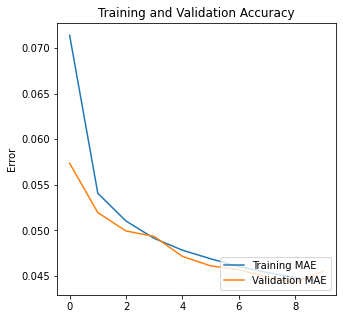

In [17]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plot_training_curves(mae, val_mae)

It is observed here that the error is dropping in the first epochs then gradualy stabilises towards $\approx$ 0.045

## Model Evaluation

In [23]:
metrics = autoencoder.evaluate(x_test,x_test)
mae = metrics[1]
print('Test Error :', mae)

157/157 [==============================] - 1s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0454
Test Error : 0.04535680636763573


We get a similar error the last epoch's validation error

In [21]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

## Display some results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


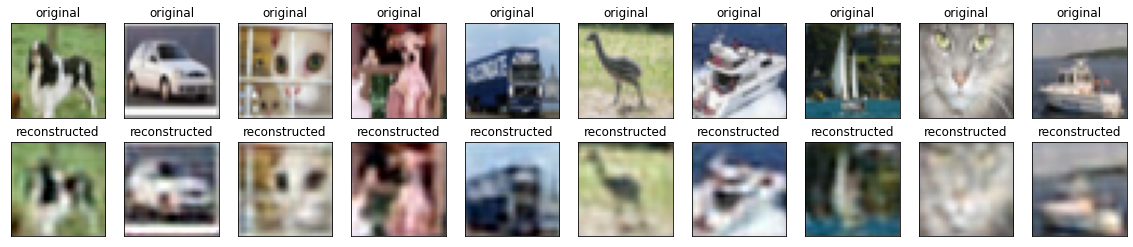

In [22]:
iStart = 10 # only change this value to display different value (must be >= 0)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[iStart + i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[iStart + i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Latent space

In [26]:
s = 1 #strides
c = 16 #channels
w = 32*32*3 #input volume
k = 3 #kernel size
p = (k-1)/2 #padding (forumla is for padding = same!)

def lspace_size(c,k,s,w,p = (k-1)/2):
   return c*np.power(1+ w-k+2*p/s,2)

print("latent space size = ",lspace_size(c,k,s,w))

latent space size =  150994944.0


# Hyper parameter tuning
> e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) 
-> What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

In [149]:
def build_ae(latent_dim = 16, verbose = 0):
    autoencoder = Autoencoder(latent_dim)
   # Define optimizer and the error function
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanAbsoluteError")
    history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                verbose=verbose,
                validation_data=(x_val, x_val))
    return history.history['val_mean_absolute_error']

error = build_ae(latent_dim = 32)
print(error)



[0.056905053555965424, 0.05250124633312225, 0.049826331436634064, 0.04696568846702576, 0.045732565224170685, 0.046203386038541794, 0.044304873794317245, 0.043693382292985916, 0.044312283396720886, 0.042922258377075195]


In [161]:
# Is there an obvious correlation between the size of the latent space representation and the error?
dims = np.power(2,np.arange(1,12,1))

errors = []
for dim in dims:
    error = build_ae(latent_dim = 32)
    errors.append(error[len(errror)]

  

[    2     4     8    16    32    64   128   256   512  1024  2048  4096
  8192 16384]


# Colorization

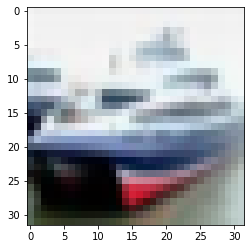

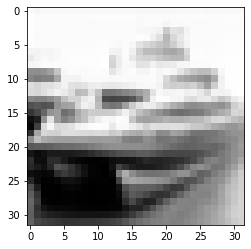

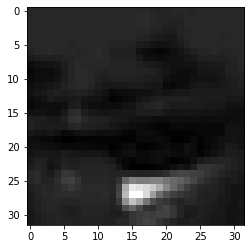

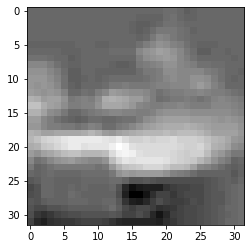

In [140]:
im_arr = x_test[1]
image = array_to_img(im_arr)
plt.imshow(image)
ycbcr = image.convert('YCbCr')
x = img_to_array(ycbcr)
image_lumina = (x.T[0][:][:]).T
plt.figure()
plt.imshow(image_lumina)
image_chroma = (x.T[1:][:][:]).T
plt.figure()
plt.imshow((image_chroma.T[1][:][:]).T)
plt.figure()
plt.imshow((image_chroma.T[0][:][:]).T)

In [ ]:
def y_chrom_convertion(data):
 new_data = []
 for im_arr in data:
  image = array_to_img(im_arr)
  ycbcr = image.convert('YCbCr')
  x = img_to_array(ycbcr)
  image_lumina = (x.T[0][:][:]).T
  image_chroma = (x.T[1:][:][:]).T


In [ ]:
# fine tune the model on the gray scale image - to rgb images task
epochs = 10 +10

history_fine = model.fit((x_train_chrom,x_train_gray_chrom),
                         epochs=epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(x_val_chrom,x_val_chrom))